In [3]:
# does H2O work better than scikit-learn?

# this notebook requires h2o server to be running and h2o python module installed.
import h2o
import os
import zipfile
import pandas as pd
import numpy as np
from scipy import stats
from datetime import date
import matplotlib.pyplot as plt
import itertools
from h2o_cust_functions import *
from ds_functions import *

from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator

# set server values here
# h2o_server = 'localhost'
h2o_server = 'nkpc'
h2o_port = 54321
max_mem_gb = 12
min_mem_gb = 4

def h2oinit():
    h2o.init(ip=h2o_server, port=h2o_port, 
         max_mem_size_GB=max_mem_gb, min_mem_size_GB=min_mem_gb)

In [4]:
# read in data

train_file = './train_users_2.csv.zip'
\
df = zip_to_df(train_file)

# Data clean up. 

df['gender'].replace('-unknown-', 'UNKNOWN', inplace=True)
df['gender'].replace(np.NaN, 'UNKNOWN', inplace=True)

# convert timestamp_first_active from string to datetime
df['timestamp_first_active'] = pd.to_datetime(df['timestamp_first_active'], format='%Y%m%d%H%M%S')

# set datetime values to datetime types
df['date_account_created'] = pd.to_datetime(df['date_account_created'])
df['date_first_booking'] = pd.to_datetime(df['date_first_booking'])


# the 'age' column has some extreme outliers and lots of missing values
# create a function for correcting values in age column, then apply
def check_age(age):
    if age in (np.nan, np.NaN):
        return np.NaN
    elif age >= 1000:
        # if age > 1000, I assume that the age value is actually birth year
        # subtract birth year from current year to calculate age
        return date.today().year - age
    else:
        return age
    
df['age'] = df['age'].apply(check_age)

# also add an age_group column

def age_group(age):
    if age in range(19):
        return '0-18'
    elif age in range(19, 26):
        return '19-25'
    elif age in range(26,36):
        return '26-35'
    elif age in range(36,51):
        return '36-50'
    elif age in range(51, 66):
        return '51-65'
    elif age > 65:
        return '66+'
    
df['age_group'] = df.age.apply(age_group)
df['age_group'].fillna('Unknown', inplace=True)
    
# calculate number of days to book 
df['days_to_book'] = df[df.country_destination != 'NDF'].date_first_booking - df[df.country_destination != 'NDF'].date_account_created
df['days_to_book'] = df.days_to_book.dt.days

# add a device class columns (desktop, phone, tablet, or unknown)

def get_device_class(val):
    if str(val).lower().find('desktop') > 0:
        return 'Desktop'
    elif str(val).lower().find('phone') > 0:
        return 'Phone'
    elif val in ('iPad', 'Android Tablet'):
        return 'Tablet'
    else:
        return 'Unknown'

df['first_device_class'] = df['first_device_type'].apply(get_device_class)

# also add a 'affiliate provider' type column

def get_aff_provider_type(val):
    search_engines = ('google', 'bing', 'baidu', 'yahoo', 
                     'yandex', 'naver', 'daum')
    direct = ('direct', 'email-marketing')
    social = ('facebook', 'meetup', 'facebook-open-graph', 'wayn')
    
    if str(val).lower() in direct:
        return 'direct'
    elif str(val).lower() in search_engines:
        return 'search'
    elif str(val).lower() in social:
        return 'social'
    else:
        return 'other'
    
df['affiliate_provider_type'] = df.affiliate_provider.apply(get_aff_provider_type)

# Separate into target and features datasets

# predictors are every variable except  country_desintation and the date values. 
# (days between date_account_created and date_first_booking is stored as calculated column)
df_dropped = df.drop(['id', 'date_account_created', 'timestamp_first_active', 
            'date_first_booking'], axis=1)
df_dropped['age'].fillna(0, inplace=True)
df_dropped['days_to_book'].fillna(100000, inplace=True)

In [5]:
# check if we can connect
h2oinit()

Checking whether there is an H2O instance running at http://nkpc:54321. connected.


H2O cluster uptime:,6 days 13 hours 32 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.5
H2O cluster version age:,15 days
H2O cluster name:,NKPC
H2O cluster total nodes:,1
H2O cluster free memory:,0
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [7]:
# read in data from pandas DF. H2O does not need to one-hot encode categorical variables
# additionally, NAs are treated as separate category and don't need to be filled in
h2o_data = h2o.H2OFrame(df_dropped)

# set categorical var columns as factor type
for col in df_dropped.drop(['age', 'signup_flow', 'days_to_book'], axis=1).columns:
    h2o_data[col] = h2o_data[col].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [8]:
# how does it look?
h2o_data.describe()


Rows:213451
Cols:16




,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,age_group,days_to_book,first_device_class,affiliate_provider_type
type,enum,int,enum,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,int,enum,enum
mins,,0.0,,0.0,,,,,,,,,,-349.0,,
mean,,21.87935872870119,,3.2673868944160356,,,,,,,,,,58365.82719687433,,
maxs,,150.0,,25.0,,,,,,,,,,100000.0,,
sigma,,21.300485849644065,,7.6377068694350605,,,,,,,,,,49276.571554605696,,
zeros,,87990,,164739,,,,,,,,,,21404,,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,UNKNOWN,0.0,facebook,0.0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,Unknown,100000.0,Desktop,direct
1,MALE,38.0,facebook,0.0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,36-50,100000.0,Desktop,search
2,FEMALE,56.0,basic,3.0,en,direct,direct,untracked,Web,Windows Desktop,IE,US,51-65,-57.0,Desktop,direct


In [9]:
target = 'country_destination'
features = list(df_dropped.drop('country_destination', axis=1).columns)

train, test = h2o_data.split_frame(ratios=[0.90])

In [10]:
# create Random Forest model & train
sqrt_features = int(np.round(np.sqrt(len(features))))
rf = H2ORandomForestEstimator(ntrees=300, 
                              max_depth=5, 
                              min_rows = 3,
                              balance_classes=True)
rf.train(x=features, y=target, training_frame=train)

# try doubling min_rows with each iteration to see the result.
# max_depth - try 5 - 10 - sqrt(# features) * 2

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [11]:
# how are the results?
# even with the training data, the model appears to be overfitting
perf = rf.model_performance(test_data=test)
perf.show()

# remember to compare training score with test score
# score from training much greater than test is indication of overfitting



ModelMetricsMultinomial: drf
** Reported on test data. **

MSE: 0.1837741346237979
RMSE: 0.4286888552596136
LogLoss: 0.6324905482562675
Mean Per-Class Error: 0.8487115208367028
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



AU,CA,DE,ES,FR,GB,IT,NDF,NL,PT,US,other,Error,Rate
0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,46.0,0.0,1.0,51 / 51
0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,117.0,0.0,1.0,143 / 143
0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,73.0,0.0,1.0,88 / 88
0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0,180.0,0.0,1.0,224 / 224
0.0,0.0,0.0,0.0,0.0,0.0,0.0,102.0,0.0,0.0,361.0,0.0,1.0,463 / 463
0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,0.0,0.0,213.0,0.0,1.0,258 / 258
0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,0.0,0.0,210.0,0.0,1.0,291 / 291
0.0,0.0,0.0,0.0,0.0,0.0,0.0,12397.0,0.0,0.0,0.0,0.0,0.0,"0 / 12,397"
0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,73.0,0.0,1.0,82 / 82
0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,12.0,0.0,1.0,20 / 20


Top-10 Hit Ratios: 


k,hit_ratio
1,0.8216255
2,0.8753828
3,0.9237221
4,0.945536
5,0.9591520
6,0.970695
7,0.9816726
8,0.9886926
9,0.9926974
10,0.9967021


In [12]:
sorted_countries = sorted(df.country_destination.unique())

cm_array = perf_to_cm_array(perf)
cm_plot(cm_array, classes=sorted(df_dropped.country_destination.unique()), 
        title='Confusion Matrix - H2O Random Forest - 12 Cateogry', normalize=True)
plt.show()
#test.describe()

NameError: name 'np' is not defined

In [95]:
h2o_even.describe()

Rows:1494516
Cols:16




,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,age_group,days_to_book,first_device_class,affiliate_provider_type
type,enum,int,enum,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,int,enum,enum
mins,,0.0,,0.0,,,,,,,,,,-349.0,,
mean,,27.472023718715583,,2.2021149321920936,,,,,,,,,,8371.785051481544,,
maxs,,150.0,,25.0,,,,,,,,,,100000.0,,
sigma,,20.45424046313281,,6.203454455484815,,,,,,,,,,27627.070883467277,,
zeros,,392332,,1190711,,,,,,,,,,305587,,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,UNKNOWN,0.0,basic,0.0,en,seo,google,linked,Web,Mac Desktop,Safari,NDF,Unknown,100000.0,Desktop,search
1,UNKNOWN,0.0,basic,24.0,en,direct,direct,omg,Moweb,Windows Desktop,IE,NDF,Unknown,100000.0,Desktop,direct
2,MALE,37.0,facebook,2.0,en,direct,direct,linked,Web,iPad,Mobile Safari,NDF,36-50,100000.0,Tablet,direct


In [171]:
# how do some of the other h2o estimators work? 
h2oinit()

def run_models(training_frame, estimator='all'):
    estimators = {
    'dl': H2ODeepLearningEstimator(),
    'gb': H2OGradientBoostingEstimator(),
    'nb': H2ONaiveBayesEstimator(),
    }
    for e in estimator:
        if e not in list(estimators.keys()) + ['all']:
            raise Exception('Invalid Estimator')
    train, test = training_frame.split_frame(ratios=[0.90])
    if estimator == 'all':
        for k, v in estimators.items():
            estimators[k].train(x=features, y=target, training_frame=train)
    else:
        for e in list(estimator):
            estimators[e].train(x=features, y=target, training_frame=train)
    return estimators

models = run_models(h2o_data, estimator=['gb', 'nb'])

Checking whether there is an H2O instance running at http://nkpc:54321. connected.


H2O cluster uptime:,5 mins 52 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.5
H2O cluster version age:,8 days
H2O cluster name:,Nick
H2O cluster total nodes:,1
H2O cluster free memory:,3.516 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


H2OResponseError: Server error java.lang.IllegalArgumentException:
  Error: Name lookup of 'py_137_sid_81ba' failed
  Request: POST /99/Rapids
    data: {'ast': '(tmp= py_162_sid_aade (h2o.runif py_137_sid_81ba -1))', 'session_id': '_sid_aade'}


In [110]:
dl_perf = dl.model_performance(test_data=test)
dl_perf.show()


ModelMetricsMultinomial: deeplearning
** Reported on test data. **

MSE: 0.7270428943572335
RMSE: 0.8526681032835891
LogLoss: 20.638733004271813
Mean Per-Class Error: 0.9166896281947646
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



AU,CA,DE,ES,FR,GB,IT,NDF,NL,PT,US,other,Error,Rate
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.0,0.0,1.0,83 / 83
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,233.0,2.0,1.0,235 / 235
0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,168.0,1.0,1.0,172 / 172
0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,333.0,3.0,1.0,340 / 340
0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,762.0,1.0,1.0,765 / 765
0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,377.0,4.0,1.0,386 / 386
0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,409.0,1.0,1.0,415 / 415
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18757.0,0.0,1.0,"18,757 / 18,757"
0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,129.0,0.0,1.0,130 / 130
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,1.0,1.0,31 / 31


Top-10 Hit Ratios: 


k,hit_ratio
1,0.2897745
2,0.3376405
3,0.3613406
4,0.3745107
5,0.3854445
6,0.3970305
7,0.4040504
8,0.4096105
9,0.4130583
10,0.4151705


In [41]:
h2oinit()

gb = H2OGradientBoostingEstimator(ntrees=300,
                                  max_depth=len(df_dropped.columns) - 1,
                                  min_rows=3,
                                  balance_classes=True)
gb.train(x=features, y=target, training_frame=train)

Checking whether there is an H2O instance running at http://nkpc:54321. connected.


H2O cluster uptime:,4 hours 5 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.5
H2O cluster version age:,8 days
H2O cluster name:,NKPC
H2O cluster total nodes:,1
H2O cluster free memory:,4.996 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [36]:
gb_perf = gb.model_performance(test_data=test)
gb_perf.show()



ModelMetricsMultinomial: gbm
** Reported on test data. **

MSE: 0.12973610800856492
RMSE: 0.36018898929390514
LogLoss: 0.5794512649657289
Mean Per-Class Error: 0.8326802696197428
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



AU,CA,DE,ES,FR,GB,IT,NDF,NL,PT,US,other,Error,Rate
0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0.0,1.0,54 / 54
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,161.0,1.0,1.0,162 / 162
0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,84.0,3.0,0.9887640,88 / 89
0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,229.0,4.0,1.0,234 / 234
0.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,472.0,2.0,0.9958246,477 / 479
0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,229.0,2.0,1.0,233 / 233
0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,286.0,5.0,1.0,293 / 293
0.0,0.0,0.0,0.0,0.0,0.0,0.0,12424.0,0.0,0.0,0.0,0.0,0.0,"0 / 12,424"
0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,68.0,0.0,1.0,69 / 69
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,1.0,25 / 25


Top-10 Hit Ratios: 


k,hit_ratio
1,0.8715287
2,0.9172043
3,0.9417485
4,0.9568490
5,0.9678822
6,0.9785882
7,0.9861150
8,0.9919121
9,0.9964470
10,0.998504


In [7]:
# also want to try 3 category classification 
def country_group(cn):
    if cn in ('NDF','US'):
        return cn
    else:
        return 'other'
    
df['country_group'] = df.country_destination.apply(country_group)
print(df.country_group.value_counts())

df_three = df.drop(['id', 'country_destination', 'date_account_created', 'timestamp_first_active', 
            'date_first_booking'], axis=1)

h2o_three = h2o.H2OFrame(df_three)

target_three = 'country_group'
features_three = list(df_three.drop('country_group', axis=1).columns)

train_three, test_three = h2o_three.split_frame(ratios=[0.90])

NDF      124543
US        62376
other     26532
Name: country_group, dtype: int64
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [8]:
h2oinit()

rf_three = h2o.estimators.H2ORandomForestEstimator(ntrees=500, max_depth=10, balance_classes=True)
rf_three.train(x=features_three, y=target_three, training_frame=train_three)

Checking whether there is an H2O instance running at http://nkpc:54321. connected.


H2O cluster uptime:,4 hours 51 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.5
H2O cluster version age:,8 days
H2O cluster name:,NKPC
H2O cluster total nodes:,1
H2O cluster free memory:,4.297 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


drf Model Build progress: |███████████████████████████████████████████████| 100%


In [36]:
rf_three_perf = rf_three.model_performance(test_data=test_three)
rf_three_perf.show()



ModelMetricsMultinomial: drf
** Reported on test data. **

MSE: 0.1038650753208752
RMSE: 0.32228105020443754
LogLoss: 0.3068079864866611
Mean Per-Class Error: 0.33320992225101814
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



NDF,US,other,Error,Rate
12234.0,0.0,0.0,0.0,"0 / 12,234"
0.0,6276.0,0.0,0.0,"0 / 6,276"
0.0,2700.0,1.0,0.9996298,"2,700 / 2,701"
12234.0,8976.0,1.0,0.1272924,"2,700 / 21,211"


Top-3 Hit Ratios: 


k,hit_ratio
1,0.8727075
2,0.9983499
3,1.0


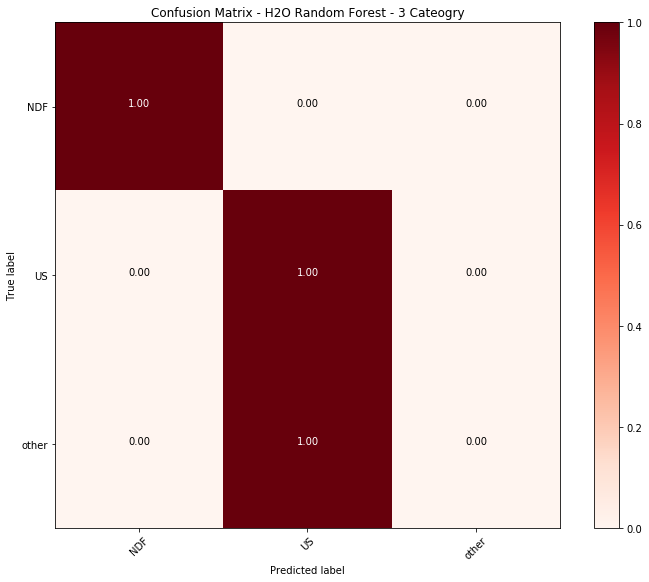

In [54]:
cm_array = perf_to_cm_array(rf_three_perf)

cm_plot(cm_array, classes=sorted(df_three.country_group.unique()), 
        title='Confusion Matrix - H2O Random Forest - 3 Cateogry', normalize=True)
plt.show()


In [13]:
# let's try this. If I eliminate NDFs, can the model tell the difference between US and other destinations?
df_nondf = df_three.loc[df_three['country_group'] != 'NDF']

h2o_nondf = h2o.H2OFrame(df_nondf)

target_nondf = 'country_group'
features_nondf = list(df_nondf.drop('country_group', axis=1).columns)

train_nondf, test_nondf = h2o_nondf.split_frame(ratios=[0.90])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [14]:
h2oinit()

rf_nondf = h2o.estimators.H2ORandomForestEstimator(ntrees=500, max_depth=10, balance_classes=False)
rf_nondf.train(x=features_nondf, y=target_nondf, training_frame=train_nondf)

Checking whether there is an H2O instance running at http://nkpc:54321. connected.


H2O cluster uptime:,4 hours 53 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.5
H2O cluster version age:,8 days
H2O cluster name:,NKPC
H2O cluster total nodes:,1
H2O cluster free memory:,4.231 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


drf Model Build progress: |███████████████████████████████████████████████| 100%


In [15]:
rf_nondf_perf = rf_nondf.model_performance(test_data=test_nondf)
rf_nondf_perf.show()

# these results are terrible. 
# does another estimator work better? 


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.20974214994780274
RMSE: 0.4579761456100118
LogLoss: 0.6093908496494969
Mean Per-Class Error: 0.4461532387526007
AUC: 0.5749962752558181
Gini: 0.14999255051163618
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23101495107263326: 


,US,other,Error,Rate
US,580.0,5528.0,0.905,(5528.0/6108.0)
other,133.0,2579.0,0.049,(133.0/2712.0)
Total,713.0,8107.0,0.6418,(5661.0/8820.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2310150,0.4767539,306.0
max f2,0.1143997,0.6899888,387.0
max f0point5,0.3023265,0.3825332,187.0
max accuracy,0.4672481,0.6930839,11.0
max precision,0.5241029,0.6666667,2.0
max recall,0.0961290,1.0,394.0
max specificity,0.5736560,0.9998363,0.0
max absolute_mcc,0.3185997,0.1053284,155.0
max min_per_class_accuracy,0.3023265,0.5523599,187.0
max mean_per_class_accuracy,0.3163181,0.5538468,160.0


Gains/Lift Table: Avg response rate: 30.75 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100907,0.4239253,1.4251268,1.4251268,0.4382022,0.4382022,0.0143805,0.0143805,42.5126777,42.5126777
,2,0.0200680,0.4051085,1.3304505,1.3780561,0.4090909,0.4237288,0.0132743,0.0276549,33.0450523,37.8056097
,3,0.0300454,0.3948802,1.6630632,1.4726999,0.5113636,0.4528302,0.0165929,0.0442478,66.3063154,47.2699950
,4,0.0400227,0.3876920,1.2195796,1.4095991,0.375,0.4334278,0.0121681,0.0564159,21.9579646,40.9599138
,5,0.05,0.3826247,1.2195796,1.3716814,0.375,0.4217687,0.0121681,0.0685841,21.9579646,37.1681416
,6,0.1,0.3630986,1.3274336,1.3495575,0.4081633,0.4149660,0.0663717,0.1349558,32.7433628,34.9557522
,7,0.1505669,0.3495794,1.2323406,1.3101910,0.3789238,0.4028614,0.0623156,0.1972714,23.2340569,31.0190985
,8,0.2,0.3396822,1.1412580,1.2684366,0.3509174,0.3900227,0.0564159,0.2536873,14.1258017,26.8436578
,9,0.3,0.3215575,1.1762537,1.2377089,0.3616780,0.3805745,0.1176254,0.3713127,17.6253687,23.7708948
,10,0.4002268,0.3108342,1.0190756,1.1829577,0.3133484,0.3637394,0.1021386,0.4734513,1.9075602,18.2957708


In [26]:
h2oinit()
# nb classifier does not work with nulls
df_nondf['age'].fillna(0, inplace=True)
df_nondf['days_to_book'].fillna(100000, inplace=True)

h2o_nondf = h2o.H2OFrame(df_nondf)

gb_nondf = h2o.estimators.gbm.H2OGradientBoostingEstimator(balance_classes=True)
gb_nondf.train(x=features_nondf, y=target_nondf, training_frame=train_nondf)

gb_nondf_perf = gb_nondf.model_performance(test_data=test_nondf)
gb_nondf_perf.show()

# these results are terrible. 
# does another estimator work better?

Checking whether there is an H2O instance running at http://nkpc:54321. connected.


H2O cluster uptime:,5 hours 27 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.5
H2O cluster version age:,8 days
H2O cluster name:,NKPC
H2O cluster total nodes:,1
H2O cluster free memory:,4.078 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pandas\core\generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.20969666647488197
RMSE: 0.4579264858848874
LogLoss: 0.6094644433750811
Mean Per-Class Error: 0.4433388534404321
AUC: 0.5756896994704948
Gini: 0.1513793989409895
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2176193789362436: 


,US,other,Error,Rate
US,549.0,5559.0,0.9101,(5559.0/6108.0)
other,120.0,2592.0,0.0442,(120.0/2712.0)
Total,669.0,8151.0,0.6439,(5679.0/8820.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2176194,0.4772162,315.0
max f2,0.1143122,0.6895848,384.0
max f0point5,0.3091558,0.3856259,174.0
max accuracy,0.5072375,0.6927438,6.0
max precision,0.5760249,1.0,0.0
max recall,0.0694094,1.0,398.0
max specificity,0.5760249,1.0,0.0
max absolute_mcc,0.3091558,0.1063772,174.0
max min_per_class_accuracy,0.2976377,0.5517354,191.0
max mean_per_class_accuracy,0.3091558,0.5566611,174.0


Gains/Lift Table: Avg response rate: 30.75 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100907,0.4478222,1.2058765,1.2058765,0.3707865,0.3707865,0.0121681,0.0121681,20.5876504,20.5876504
,2,0.0200680,0.4296608,1.5521923,1.3780561,0.4772727,0.4237288,0.0154867,0.0276549,55.2192277,37.8056097
,3,0.0300454,0.4126796,1.7000201,1.4849724,0.5227273,0.4566038,0.0169617,0.0446165,70.0020113,48.4972449
,4,0.0400227,0.4072583,1.2934936,1.4372383,0.3977273,0.4419263,0.0129056,0.0575221,29.3493564,43.7238336
,5,0.0506803,0.4007546,1.3839202,1.4260260,0.4255319,0.4384787,0.0147493,0.0722714,38.3920166,42.6026014
,6,0.1,0.3759666,1.3083613,1.3679941,0.4022989,0.4206349,0.0645280,0.1367994,30.8361306,36.7994100
,7,0.15,0.3605344,1.2241888,1.3200590,0.3764172,0.4058957,0.0612094,0.1980088,22.4188791,32.0058997
,8,0.2,0.3483512,1.1504425,1.2776549,0.3537415,0.3928571,0.0575221,0.2555310,15.0442478,27.7654867
,9,0.3,0.3274813,1.1356932,1.2303343,0.3492063,0.3783069,0.1135693,0.3691003,13.5693215,23.0334317
,10,0.4,0.3103344,1.0877581,1.1946903,0.3344671,0.3673469,0.1087758,0.4778761,8.7758112,19.4690265
